# The Constrained / Unconstrained Domains & Getting Likelihoods from MCMC

The moment you start trying to do anything fancy with NumPyro, it's only a matter of time before you find yourself running into issues with the constrained and unconstrained domain. NumPyro uses JAX's autodiff for a lot of its functionality: these gradients don't make sense if you have any distribution / prior with discontinuities, and so NumPyro internally performs a coordinate transformation from these _discontinuous_ distributions to a new domain with _continuous_ distributions. The danger comes in the fact that _some_ of NumPyro's features want arguments specified in this unconstrained domain, but it's not always easy to tell which at first glance.

In this example, we cover a simple 1D example of how to transform parameters between the constrained and unconstrained domain and how to use this to similarly adjust a likelihood function, and then apply these techniques to an MCMC chain to show how you can use NumPyro's normal MCMC methods to also report the likelihood at each sample.

**Index**
- [Explanation of The Constrained / Unconstrained Domain](#The-Constrained-&-Unconstrained-Domain)
- [Getting Likelihoods from MCMC Chains](#Using-Domain-Transforms-to-get-MCMC-Sample-Likelihood)
- [Specifying MCMC Start Positions](#Specifying-MCMC-Start-Positions)

In [3]:
# Statistical + JAX Tools
import jax, numpyro
import jax.numpy as jnp
from numpyro.infer.util import transform_fn

# Utility, Math & Plotting
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

## The Constrained & Unconstrained Domain

In this section, we look at how a simple uniform distributed parameter, $x \sim U(2,2)$, is re-parameterized by NumPyro into a domain where the sharp discontinuities at the edges of this prior are removed. First, we need to make sure we have the `transform_fn` function, which is the engine for changing parameters from one domain to the other. I'll also define a NumPyro model, keeping the uniform distribution as its own separate python object as we need to feed it into our transformation later.

In [8]:
from numpyro.infer.util import transform_fn

dist = numpyro.distributions.Uniform(0,2) # The NumPyro distribution that is going to get transformed
def model_test():
    x = numpyro.sample('x', dist)

Now the steps for transforming from the "constrained" domain, i.e. the "real" values of x, to the "unconstrained" domain. First, we generate a range of 'x' values that span the values allowed by the uniform distribution, $x \in [0,2]$, then we transform these in a two-step process:
1. First, we need to tell NumPyro what distributions we're working with in the dictionary `transforms`
2. Then we apply these transformations with `transform_fn`, specifying which values we're transforming with the second argument and that we're pulling from the unconstrained to the constrained domain with `invert=True`
This second step transforms the entire dictionary and returns as another dictionary with similar keys, and so we need to extract the specific key `'x'`. Notice that, if we had many variables, we could transform them all in one go by making a dictionary with all parameters / transformations at once.

By plotting the transformation, we can see that it does two things:
1. The transformed values are _unconstrained_, i.e. $x_{uncon} \in (-\infty,\infty)$
2. They are 'normalized' such that the "central" value of $x_{con}=1$ transforms to $x_{uncon} = 0$

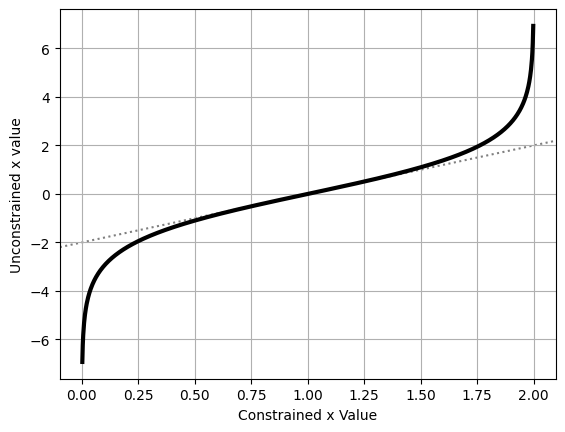

In [9]:
transforms = {"x": numpyro.distributions.biject_to(dist.support)}

x_con = np.linspace(0, 2, 1024)
x_uncon = transform_fn(transforms, {'x': x_con}, invert=True)['x']

#---------------------------------
# Plotting
plt.plot(x_con, x_uncon, c='k', lw=3)
plt.axline( [1,0], slope=2, zorder = -1, c='k', ls=':', alpha = 0.5)
plt.xlabel("Constrained x Value")
plt.ylabel("Unconstrained x value")
plt.grid()
plt.show()

Converting the variables between the constrained and unconstrained domains is easy enough, as shown above, but feeding these directly into a likelihood function won't give us the right answer. Instead, we need to weight by the *derivative* of this transformation to recover the correct probability. If you're not familiar with how probability distributions change with coordinate transformations, the key idea is that corresponding differential elements have the same amount of "power" in either coordinate system:

$$
    P(x_{con}) \cdot dx_{con} = P(x_{uncon}) \cdot dx_{uncon}
$$

Such that the distribution transforms like:

$$
    P(x_{con}) = P(x_{uncon}) \cdot \frac{dx_{uncon}}{dx_{con}}
$$

Note that this equation is specific to the one dimensional case. In the more general sense, we multiply by the determinant of the Jacobian of the transformation. As a first pass, we'll get the derivative using crude finite differences:

In [10]:
diff = (x_uncon[2:]-x_uncon[:-2]) / (x_con[2:]-x_con[:-2])

Now we feed our unconstrained parameters into the likelihood function, which we access from the `potential_energy` utility function that NumPyro gives us. This potential energy returns the **negative log likelihood**. For our model `model_test()`, this looks something like:

$PE(x_{uncon}) = -ln\vert\mathcal{L(x_{uncon})}\vert=$ `numpyro.infer.util.potential_energy(model_test, model_args=(), model_kwargs={}, params={'x': x})`

Even though we have no model `args` or `kwargs`, these fields still have to be explicitly given as empty tuples like above. In a more complicated case with data, e.g. `model_with_data(X,Y,E)`, these would be fed into the `model_args` field.

Using this approach, we can evaluate our likelihoods in the unconstrained domain, and then correct them back to the constrained domain with our derivative:

INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode


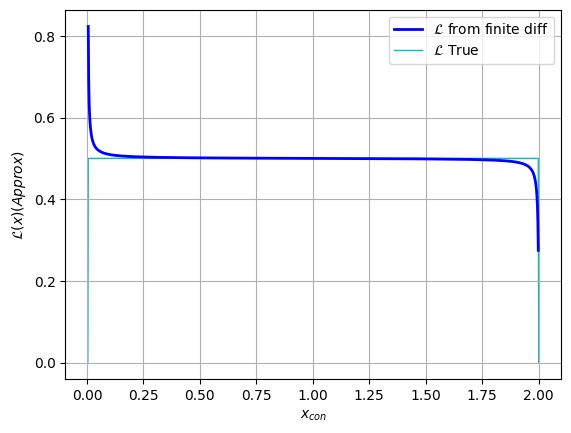

In [11]:
# Get potential energies
PE = [numpyro.infer.util.potential_energy(model_test, model_args=(), model_kwargs={}, params={'x': x}) for x in x_uncon]
PE = np.array(PE)

# Convert to likelihood
L = np.exp(-PE)

# Weight by transformation derivative
y= L[2:] * diff

# True model for comparison
y_true = 0.5*(x_con[2:]>0.0)*(x_con[2:]<2.0)
y_true[0] = 0
y_true[-1]= 0

# Plot
plt.plot(x_con[2:], y, c='blue', lw=2, label = "$\mathcal{L}$ from finite diff")
plt.plot(x_con[2:], y_true, c='c', lw=1, zorder=-1, label = "$\mathcal{L}$ True")

plt.legend(), plt.grid()
plt.xlabel("$x_{con}$"), plt.ylabel("$\mathcal{L}(x) (Approx)$")
plt.show()

Looking above, we can see that the likelihood function plateaus at $\mathcal{L}\approx 0.5$ for most of the domain, and is constrained to $x \in [0,2]$, both of which are what we expect from our $x \sim U(0,2)$ distribution. The unusual behaviour at the edges of the domain is a result of our poor estimate of $\frac{dx_{uncon}}{dx_{con}}$ clashing with the extreme gradients of the transformation at these points.

Fortunately, we can use JAX's native auto-differentiation to get an *analytically accurate* derivative function. First, re-define the transformation function to be a bit easier to read, and then apply JAX's auto-diff to this, which is as easy as using `jax.grad(function)`:

In [12]:
def tform(x):
    out = transform_fn(transforms, {'x': x}, invert=True)['x']
    return(out)

tform_diff = jax.grad(tform)

Now take these two functions, along with the likelihood evaluation we saw before, and bring it all together in a single function:

In [28]:
def l_uncon(x):
    xdash = tform(x)
    diff  = tform_diff(x)
    
    ll  = numpyro.infer.util.potential_energy(model_test, model_args=(), model_kwargs={}, params={'x': xdash} )
    out = jnp.exp(-ll) * diff
    return(out)

l_uncon = jax.vmap(l_uncon)

In the last line, the `l_uncon(x)` function has been `vmapped` by JAX, making it an efficient vectorized function. Just like using JAX's `jax.jit(function)` decorator, we can only transform functions that are at the top level. Now, we can apply this function to an entire sequence of values without issue:

INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol L from STIXNonUnicode


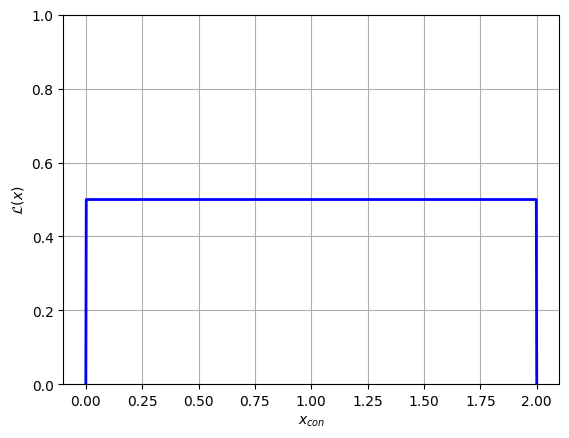

In [14]:
# Evaluate and set any nan (out of domain) values to zero
y = l_uncon(jnp.array(x_con))

# -------------------
y = jnp.nan_to_num(y, copy=False, nan=0.0) # A mask that stops errors at the poorly defined boundaries

# Plot
plt.plot(x_con, y, c='blue', lw=2)
plt.ylim(ymin=0, ymax = np.max(y)*2), plt.grid()
plt.xlabel("$x_{con}$"), plt.ylabel("$\mathcal{L}(x)$")
plt.show()

In this example we transformed _into_ the unconstrained domain, but transforming back out is as simple as swapping `invert=True` to `False`. Knowing how to convert between the two domains is important for cases like running multiple MCMC chains with different start locations and retrieving sample likelihoods from an MCMC chain. In the following section, we cover an example of this second application.

## Using Domain Transforms to get MCMC Sample Likelihood

In this section we tackle two problems: 
1. Firstly, how to get a NumPyro MCMC sampler to record information about the likelihood of the MCMC samples
2. Secondly, how to use the information about the constrained / unconstrained domain from the previous section to convert this information into a useful value

To keep things simple, we'll use a simple unimodal Gaussian and uniform priors. In this example, we set up our NumPyro model slightly differently to normal: instead of using a the `numpyro.distributions.Normal` prior for $x$ and $y$, we'll instead use _uniform_ priors and use `numpyro.factor`, which lets as multiply our posterior distribution  by some arbitrary factor / function. Given our model is Gaussian, the two approaches are equivalent (plus or minus a normalization constant) and we're only doing this here so that we have a readily evaluable probability function to test against down the track.

In [20]:
#----------------------
# Parameters / prior volume
xmin, xmax = -5, 10
ymin, ymax = -8, 8
V0 = (xmax-xmin) * (ymax-ymin) # Prior vol
#----------------------

# Probability func w/o prior
def prob_func(x,y):
    out=0
    out+=jnp.exp(-1/2 * ((x)**2+y**2))
    return(out)

# Log Probability function
def log_prob_func(x,y):
    return(jnp.log(prob_func(x,y)))

# Numpyro model + prior distributions
distx = numpyro.distributions.Uniform(xmin,xmax)
disty = numpyro.distributions.Uniform(ymin,ymax)
def np_model():
    x = numpyro.sample('x', distx)
    y = numpyro.sample('y', disty)

    numpyro.factor(name="prob_fac", log_factor = log_prob_func(x,y))

### Generating MCMC-Like Chains

Now fire a standard MCMC run at this using NUTS. In a simple distribution like this, a single chain should be fine. Note that, when running the MCMC sampler, we instruct it to also log "`extra_fields`" like the potential energy etc. We can do this for **any value tracked by the sampler state**. e.g. we're using `NUTS`, a type of HMC, so we can instruct NumPyro to track any of the values listed in the [HMCstate](https://num.pyro.ai/en/stable/mcmc.html#numpyro.infer.hmc.HMCState) class (e.g. `z_grad`: the grad vector or `i`, the iteration number)

In [21]:
# Construct the NUTS sampler
MCMC_sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(np_model), 
    num_chains=1,
    num_warmup=1000, 
    num_samples=int(50000))

# Run and acquire results, also storing potential energy
MCMC_sampler.run(jax.random.PRNGKey(1), 
                 extra_fields=("potential_energy",)
                 ,)
MCMC_results = MCMC_sampler.get_samples()

sample: 100%|███████| 51000/51000 [00:11<00:00, 4402.70it/s, 3 steps of size 7.34e-01. acc. prob=0.94]


Sampling done


In HMC, potential energy is proportional to $\chi^2$:

$$
    U_x(x) = -ln\vert \mathcal{L_x(x)} \vert =\frac{-\chi^2}{2}
$$

NumPyro uses this terminology consistently across all of its samplers, e.g. the sampler adaptive sampler ([SAstate](https://num.pyro.ai/en/stable/mcmc.html#numpyro.infer.sa.SAState)) also refers to 'potential energy' despite not actually being formulated in kinetic terms. As an aside, the 'extra fields' tuple can sometimes play up if you don't have a comma after the last argument. E.g. `extra_fields=("potential_energy",)` will work, but `extra_fields=("potential_energy")` won't. 

Now, plot these results in chainconsumer to confirm everything is working correctly. As expected, we see a bivariate Gaussian with $\sigma_x=\sigma_y=1$:

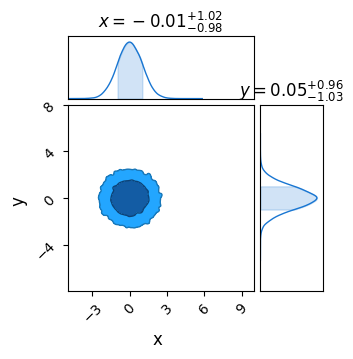

In [22]:
c = ChainConsumer()
c.add_chain(MCMC_results, name = "MCMC")
c.plotter.plot(extents = {'x':[xmin,xmax], 'y':[ymin,ymax]})
plt.show()

Any extra info is stored in a dictionary accessible through `sampler.get_extra_fields()`. I'm also going to calculate the *true* likelihood of each point to demonstrate an issue with this approach.

When we plot the two against each other, we see the proportionality is _almost_ right, but something is clearly going wrong.

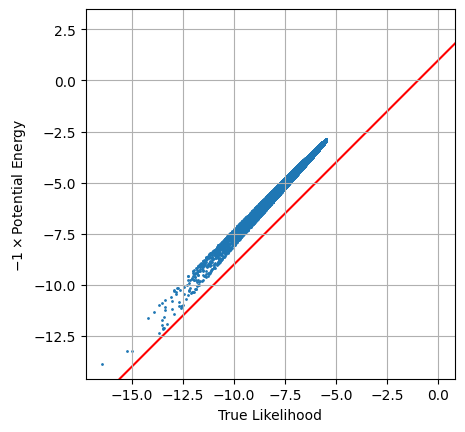

In [27]:
# Extract info from MCMC sampler object
extra_fields = MCMC_sampler.get_extra_fields()
pot_en = extra_fields['potential_energy']

# Get true likelihood for all points for comparison / demonstration purposes
X, Y = MCMC_results['x'], MCMC_results['y']
Ltrue = np.array([prob_func(x,y) for x,y in zip(X, Y)]) / V0 # factor of V0 represents attenuation by the prior
logLtrue = np.log(Ltrue)

#--------------------------
# Plotting
plt.scatter(logLtrue, -1 * pot_en, s=1)
plt.axline([0,1], slope=1,c='r',zorder=-1)

plt.axis('square'), plt.grid()
plt.xlabel("True Likelihood"), plt.ylabel("$-1 \\times $Potential Energy")
plt.show()

The issue here is simple: this `potential energy` is defined in terms of the **unconstrained parameter space**, and so we need to do a transformation back to real parameter space using a conversion factor $U_\theta(\theta) = U_x(x) \cdot D$. Our prior distribution is seperable ($x$ and $y$ are uncorrelated in the prior) so this is as simple as multiplying the gradients together:

$$
    D=\Pi_i \left( \frac{dx'_i}{d\theta_i} \right)
$$

This is simple enough to do, all we have to do is:
1. Get the transformation functions from $x\leftrightarrow\theta$
2. Take their gradient using `jax.grad`
3. Get a function that takes their product to get the conversion factor

In the following, I just JAX's `jax.vmap` so that our final function can process all of the MCMC chain at once, this time applying JAX's function transformations using decorators:

In [24]:
transforms = {"x": numpyro.distributions.biject_to(distx.support), "y": numpyro.distributions.biject_to(disty.support)}

@jax.grad
def _tformx(x):
    out1 = transform_fn(transforms, {'x': x}, invert=True)['x']
    return(out1)
    
@jax.grad
def _tformy(y):
    out2 = transform_fn(transforms, {'y': y}, invert=True)['y']
    return(out2)
    
@jax.vmap
def tform_diff_xy(x,y):
    out = _tformx(x) * _tformy(y)
    return(out)

Equipped with this, we can easily get the required scaling for each sample and then apply this factor to transform `potential energy` into a true `log_likelihood`.  Plotting the two against each other, we can confirm that this new transformed value is the property that we're after:

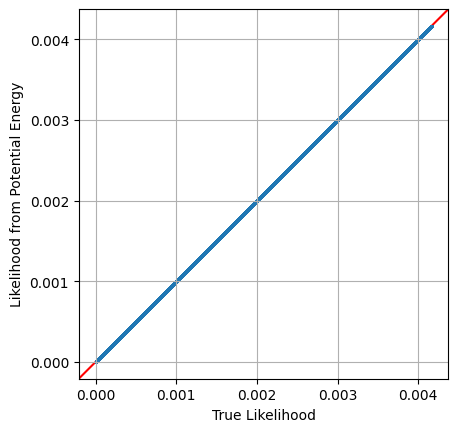

In [25]:
# X,Y are coordinates from MCMC chain
diff_scaling = tform_diff_xy(X,Y) # get coordinate change scaling
L_from_MCMC = np.exp(-pot_en) * diff_scaling # Convert potential energy to likelihoods

# plot against direct likelihood
plt.scatter(Ltrue,L_from_MCMC, s=1)
plt.axline([0,0], slope=1, c='r',zorder=-1)
plt.axis('square')
plt.grid()
plt.xlabel("True Likelihood")
plt.ylabel("Likelihood from Potential Energy")
plt.show()

## Specifying MCMC Start Positions
One area that the confusion between constrained and unconstrained domains rears its head is in the all-too-common case of trying to nominate a starting position for an MCMC run. Though NumPyro does have a considerable suite of [initialization strategies](https://num.pyro.ai/en/stable/_modules/numpyro/infer/initialization.html), it's easy to imagine cases where we might want more direct control. In this section, I'm going to demonstrate how to use the `constrain_fn` and `unconstrain_fn` utilities specify bespoke initial conditions for a set of MCMC chains, the kind of thing you can easily imagine using for multimodal problems or distributions with fiddly geometry.

To keep things simple, suppose we have a model with a simple 2D Gaussian posterior in parameters $x$ and $y$, constrained by a uniform prior, $x,y\in[-10,10]$:

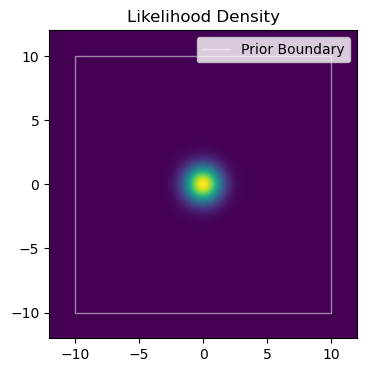

In [32]:
# REDACT
def model():
    x = numpyro.sample('x', numpyro.distributions.Uniform(-10,10))
    y = numpyro.sample('y', numpyro.distributions.Uniform(-10,10))
    numpyro.factor('poten',-(x**2+y**2)/2)

plt.figure(figsize=(4,4))
Xg, Yg = np.meshgrid(np.linspace(-12,12,256), np.linspace(-12,12,256))
Zg = np.exp(-(Xg**2+Yg**2)/2)
plt.imshow(Zg, extent = (-12,12,-12,12), label = 'Likelihood')
plt.plot([10,10,-10,-10,10], [10,-10,-10,10,10], c='w', lw=1, alpha=0.5, label = 'Prior Boundary')
plt.legend( loc = 'upper right')
plt.title("Likelihood Density")
plt.show()

Now suppose we want to start $4$ MCMC chains at some pre-determine positions. For demonstrating, I'm going to put them in a cross at $\pm 5$ from the origin, i.e.:

$$
(x_0,y_0) = ([0,5],[5,0],[0,-5],[-5,0])
$$

First, lets create a sampler as per normal. Here, I've set `step_size` to be small to better see the initial movement of the walkers, and for the same reason set this to be all `warmup` phase, with as few `num_samples` as I can get away with. Though I'm doing this for demonstration / validation, it can sometimes be good to set a small `step_size` in cases like this to make sure your sampler doesn't jump away from your starting position, especially for narrow modes.

In [59]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(model, step_size = 1E-10),
    num_chains = 4,
    num_samples = 1,
    num_warmup = 1_000
)

/tmp/ipykernel_503/1458533417.py:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = numpyro.infer.MCMC(


Now, we're going to take our starting positions and encode them in a dictionary, `init_pos`, keyed by parameter name:

In [60]:
init_pos = {'x': jnp.array([0,5,0,-5]),
            'y': jnp.array([5,0,-5,0])
           }

Now the interesting part. We're going to convert this to auto-grad friendly unconstrained parameter space using the `unconstrain_fn` utility. This does the same thing as the `transform_fn` utility in our previous example, but automatically reads in all of the information about the prior from `model`, saving us some legwork.

In [61]:
init_pos_uncon = numpyro.infer.util.unconstrain_fn(model=model, 
                                                   model_args=(), 
                                                   model_kwargs={}, 
                                                   params=init_pos
                                                  )

In this stripped-down example, we don't have any data or arguments and so `model_args` and `model_kwargs` are blank. We then feed these initial positions to directly into the sampler at the `.run()` or `.warmup()` command. Again, for plotting purposes, I'm only running the warmup phase and collecting samples from it to make sure I capture the first movements of the walkers:

In [66]:
sampler.warmup(jax.random.PRNGKey(1), 
               init_params = init_pos_uncon, 
               collect_warmup =True
              )
res = sampler.get_samples()
nchains = sampler.num_chains

warmup: 100%|█████████| 1000/1000 [00:00<00:00, 7661.82it/s, 1 steps of size 8.99e-01. acc. prob=0.80]


Now we can plot to confirm that these starting positions have all worked correctly:

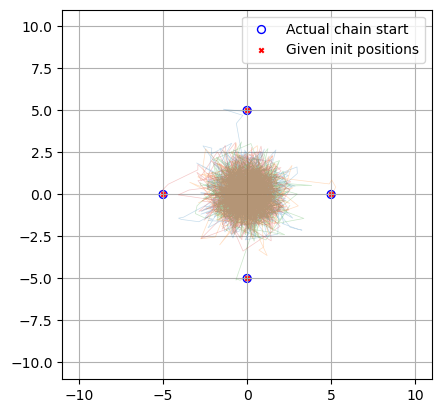

In [75]:
plt.figure()
label = 'Actual chain start'
for i in range(nchains):
    plt.plot(res['x'][i*nsamples:(i+1)*nsamples], res['y'][i*nsamples:(i+1)*nsamples], lw=.5, alpha=0.25)
    plt.scatter([res['x'][i*nsamples]], [res['y'][i*nsamples]], marker = 'o', facecolor='none', edgecolor='blue', s = 32, label = label)
    label = None

plt.axis('square'), plt.grid()
plt.scatter([init_pos['x']], [init_pos['y']], c='r', marker = 'x', s = 10, label = 'Given init positions')
plt.legend()
plt.xlim(-11,11), plt.ylim(-11,11)
plt.show()

In this example setting the sampler `step_size` at a low value means that NUTS began by taking small cautious steps about its initial positions. The warmup phase of NUTS includes a step-scaling phase here it tunes this parameter (see the [old stan documenation](https://mc-stan.org/docs/2_19/reference-manual/hmc-algorithm-parameters.html) for a good overview), and so the walkers ramp up their speed as they move. This early caution isn't needed in our toy example, but can become necessary if your starting positions are bracketed by dangers "high gradient" regions (see my [guide](https://hughmcdougall.github.io/blog/02_numpyro/03_mcmcsamplers/page.html) on multi-modality and aliasing for an example). You can easily get unlucky and shoot right off the high-likelihood island of stability and lose all the benefits of your initial position.

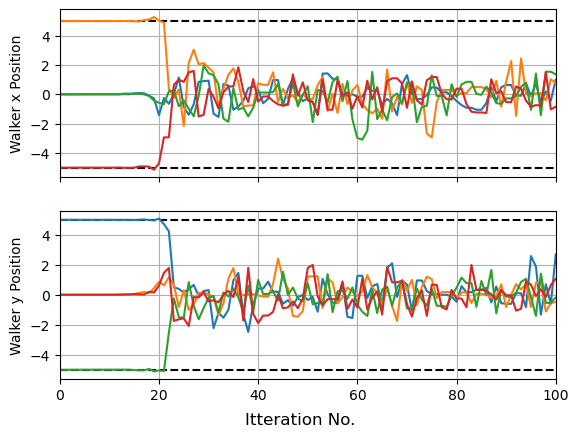

In [77]:
fig, (a1,a2) = plt.subplots(2,1, sharex=True)

for i in range(nchains):
    a1.plot(res['x'][i*nsamples:(i+1)*nsamples], lw=1.5)
    a2.plot(res['y'][i*nsamples:(i+1)*nsamples], lw=1.5)
plt.xlim(xmin=0, xmax=100)
a1.grid(), a2.grid()
fig.supxlabel("Itteration No.")
a1.set_ylabel("Walker x Position"), a2.set_ylabel("Walker y Position")
for a in [-5,5]:
    a1.axhline(a,c='k',ls='--', zorder=-1), a2.axhline(a,c='k',ls='--', zorder = -1)
plt.show()